<h1><center>Exercise 7 </center></h1>
<h2><center>Image analysis using watershed</center></h2>

The purpose of this exercise is to familiarise the student with the use of advanced tools of morfological image processing in python. We will be working with the image 'cells.jpg', it's and RGB image taken with a microscope of a number of colored cells.

Our objective is to automate the process of counting the number of nuclei in the image using segmentation and mathematical morphology. This creates an alternative to the method of manual counting still in use. This process is really complicated to automate and getting the correct results since some cells can be overlapping in the image.

In [3]:
#importamos librerías necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from imregionalmax import imregionalmax
from imreconstruct import imreconstruct
import skimage.measure as sk

1. Preprocessing

First read and display 'cells.jpg' as a gray scale image.

<IPython.core.display.Javascript object>


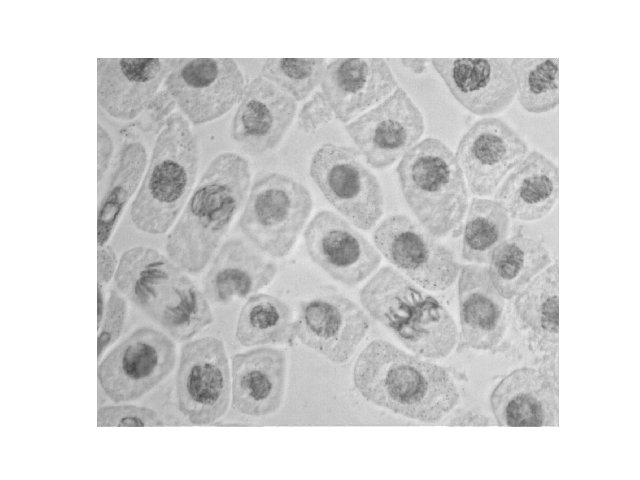

In [4]:
%matplotlib notebook
I = cv2.imread('cells.jpg', 0)
Icolor = cv2.imread('cells.jpg', 1)

plt.figure(1)
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.show()


Now filter the image using an alternate sequential filter (ASF3) open-close with an circular structuring element of increasing radius (radius 1, radius 2, radius 3).

An alternate sequential filter is a filter that alternates filtering an image using the morphological operations open and close with structuring elements of varying sizes.

Display the result after each iteration of the filter and the final result, save this result in a variable named ASF3.

Remember the different functions necessary for morphological operations like cv.getstructuringElement and cv2.morphologyEx

In [5]:
EE1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
EE2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
EE3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))


open1 = cv2.morphologyEx(I, cv2.MORPH_OPEN, EE1)
clos1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, EE1)
open2 = cv2.morphologyEx(clos1, cv2.MORPH_OPEN, EE2)
clos2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, EE2)
open3 = cv2.morphologyEx(clos2, cv2.MORPH_OPEN, EE3)
I_ASF3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, EE3)


<IPython.core.display.Javascript object>


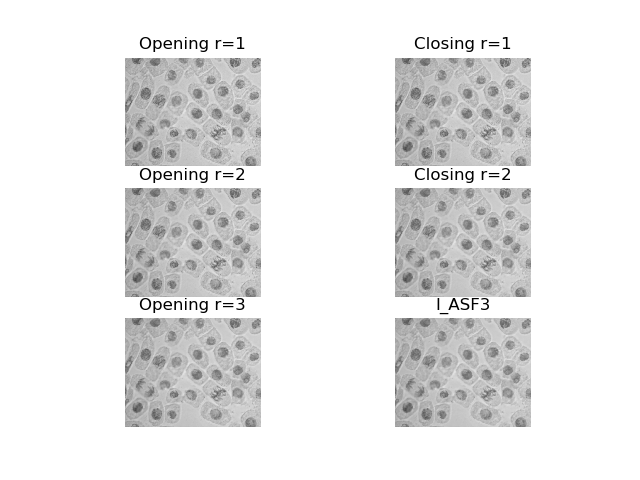

(-0.5, 1279.5, 1023.5, -0.5)

In [6]:
f, axarr = plt.subplots(3, 2)

axarr[0,0].imshow(open1, cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,0].set_title('Opening r=1')
axarr[0,0].axis('off')
axarr[0,1].imshow(clos1, cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,1].set_title('Closing r=1')
axarr[0,1].axis('off')
axarr[1,0].imshow(open2, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,0].set_title('Opening r=2')
axarr[1,0].axis('off')
axarr[1,1].imshow(clos2, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,1].set_title('Closing r=2')
axarr[1,1].axis('off')
axarr[2,0].imshow(open3, cmap = 'gray', vmin = 0, vmax = 255)
axarr[2,0].set_title('Opening r=3')
axarr[2,0].axis('off')
axarr[2,1].imshow(I_ASF3, cmap = 'gray', vmin = 0, vmax = 255)
axarr[2,1].set_title('I_ASF3')
axarr[2,1].axis('off')

2. Watershed segmentation

[Watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing)) is a segmentation algorithm tha uses used defined markers, it's based on comparing the image to a topographic landscape with ridges and valleys. The valleys are indicated with markers and the algorithm simulates these intensity valleys filling up with water, where the water reaches is a region.

![watershed](watershed.png)

2.a. Obtaining the cell markers

The marker of the cell must be inside the nucleus in the "dark" part of the cell. To extract this markers follow the process outlined bellow:

    i. Get the negative image of I_ASF3. Call this new image I_neg

In [7]:
I_neg = 255 - I_ASF3

    ii. Use erosion with an structuring element with a radius of size 25 to get I_marker

In [8]:
EEnuevo = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
I_marker = cv2.erode(I_neg,EEnuevo,iterations = 1)

     iii. recontruction of I_neg using I_marker as marker.
     
     Reconstruction is a morphological operation that consist of repeated dilations of an image(marker) until the contour of the marker fits under a second image (mask).
     To do the reconstruction we will be using the function reconstruction from skimage.morphology. This functionrecieves two arguments, first a marker image and second the mask image, in this case I_marker and I_neg: the function returns the reconstructed image I_rec.
     

In [9]:
I_rec = imreconstruct(I_marker, I_neg)

[[87 87 87 ... 62 62 62]
 [84 84 84 ... 62 62 62]
 [84 84 83 ... 62 62 62]
 ...
 [80 80 80 ... 49 49 49]
 [80 80 80 ... 49 49 49]
 [80 80 80 ... 49 49 49]]


In [10]:
from skimage.morphology import reconstruction
I_rec = reconstruction(I_marker, I_neg)


    iv. Get a binary image where the foreground pixels are part of the regional maxima of the recontructed image. 
    The regional maxima are the region ( connected groups of pixels with the sema intensity level) that have a higher intensity than all the pixels surrounding it.
    To get this binary image call the functionimregionalmax from the file "imregionalmax.py".
    It teks a few minutes to complete de process. This new image must be called I_max_reg.
    Display the results.

In [11]:
I_max_reg = imregionalmax(I_rec)

int32
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Compare the image I_max_reg with the original image. As you can see not al foreground pixels coincide with cells on the original image. To clean the image we will be using several processes.

- Clear border 

    First we are not interested on counting the cells in the border since they are not whole. To get rid of these markers in the border use the function clearborder imported below. Clear border asks a second parameter, the distance it should consider as a border, use 5. Call this image I_max_reg2

In [12]:
from clearborder import imclearborder

I_max_reg2 =  imclearborder(I_max_reg, 5)

- Keep bigger regions

    As we did on exercise 4 filter out the smaller regions, use a minimum area of 200

<IPython.core.display.Javascript object>


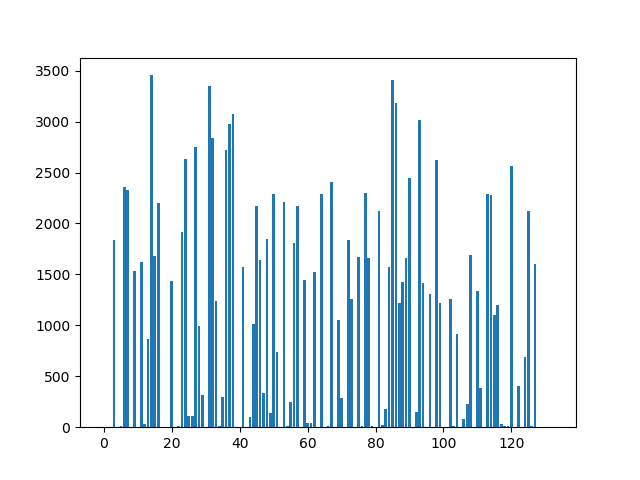

In [14]:
cc, Nobjects = sk.label(I_max_reg2, return_num=True)
props = sk.regionprops(cc)
V_Area = [0]
for i in range(0, Nobjects):
    V_Area.append(props[i].area)


plt.figure('V_Area')

plt.bar(np.arange(len(V_Area)), V_Area)
plt.show()

<IPython.core.display.Javascript object>


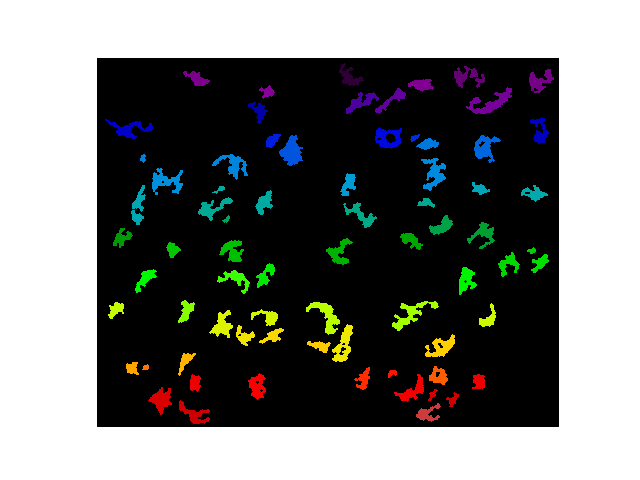

In [15]:

V_No_Interest = []
V_interest = []
for i in range(0, Nobjects):
    if V_Area[i] <= 200:
        V_No_Interest.append(i)
    else:
        V_interest.append(i)

for i in V_No_Interest:
    cc[cc == i] = 0

plt.figure('New Binary image')
plt.imshow(cc,cmap=plt.cm.get_cmap('nipy_spectral'))
plt.axis('off')
plt.show()

- Check if the regions coincide with a cell

    Using the property mean intensity of regionprops and knowing that in the original image the maximum intensity value of a nucleus is 15 we can filter out all the markers that don't fall under a cell. 
    Remember that regionprops as a second argument can receive a gray scale image.
    

<IPython.core.display.Javascript object>


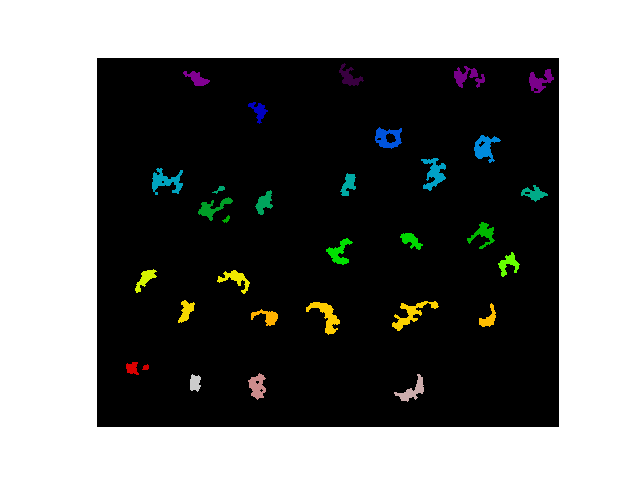

In [16]:
from skimage.measure import label, regionprops

props = regionprops(cc, I)

for i in range(0,len(props)):
    if props[i].mean_intensity >=150:
        cc[cc==props[i].label] = 0

At this point you should have a labelled image, turn it in to a binary uint8 image called I_max_reg3.

Display in a subplot the following images: 
    - I_neg
    - I_marker
    - I_rec
    - I_max_reg
    - I_max_reg2
    - I_max_reg3

In [17]:
I_max_reg3 = cc.astype(np.uint8)
I_max_reg3[I_max_reg3!=0] =255

<IPython.core.display.Javascript object>


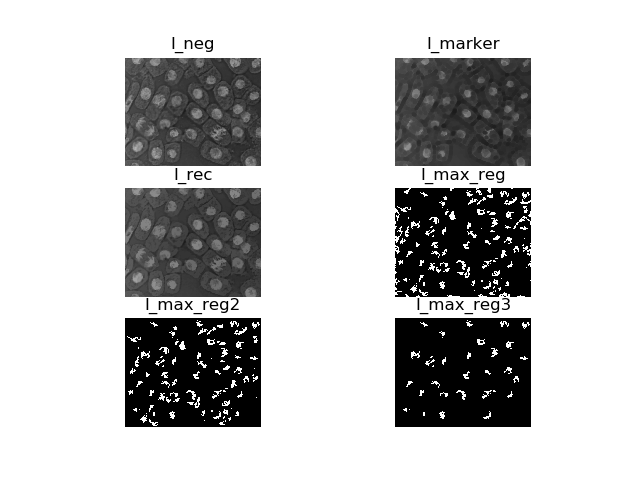

(-0.5, 1279.5, 1023.5, -0.5)

In [18]:
f, axarr = plt.subplots(3, 2)

axarr[0,0].imshow(I_neg, cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,0].set_title('I_neg')
axarr[0,0].axis('off')
axarr[0,1].imshow(I_marker, cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,1].set_title('I_marker')
axarr[0,1].axis('off')
axarr[1,0].imshow(I_rec, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,0].set_title('I_rec')
axarr[1,0].axis('off')
axarr[1,1].imshow(I_max_reg, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,1].set_title('I_max_reg')
axarr[1,1].axis('off')
axarr[2,0].imshow(I_max_reg2, cmap = 'gray', vmin = 0, vmax = 255)
axarr[2,0].set_title('I_max_reg2')
axarr[2,0].axis('off')
axarr[2,1].imshow(I_max_reg3, cmap = 'gray', vmin = 0, vmax = 255)
axarr[2,1].set_title('I_max_reg3')
axarr[2,1].axis('off')

2.b. Obtaining the external markers

As the external markers we will be using the watershed lines obtained over the distance transform of I_max_reg3 previously dilated(I_minimos) with a disk of radius 3 so the external markers don't coincide with a cell.

For this you will need two new functions. First cv2.distanceTransform which takes a binary imagea returns a new image(D) in which the value of each pixel is the distance from tha pixel to the closest pixel of value 0. Since we are going to be using watershed we want the internal markers to bethe lowest value, use the negative of I_minimos for the distance transform.

The other new function is watershed from skimage.morphology, this function performs the watershed algorithm, the first parameter is the image we want to label.  It also can receive as a second parameter another matrix of the same shape a the image with the markers for the seed of the watershed, if this matrix is not given the function uses the local minima as seeds. This function also has the optionof marking the watershed lines with a 0 in the return image(DL). Look up how to do thid [here](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed).

Display as 3d graphs the result of all 3 steps to get the external markers.

<IPython.core.display.Javascript object>


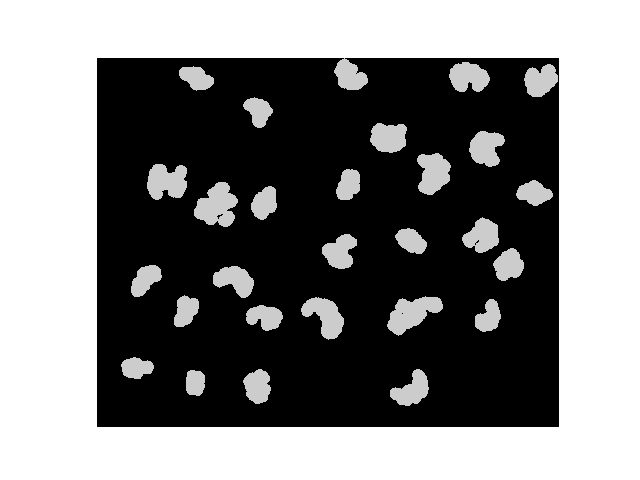

<IPython.core.display.Javascript object>


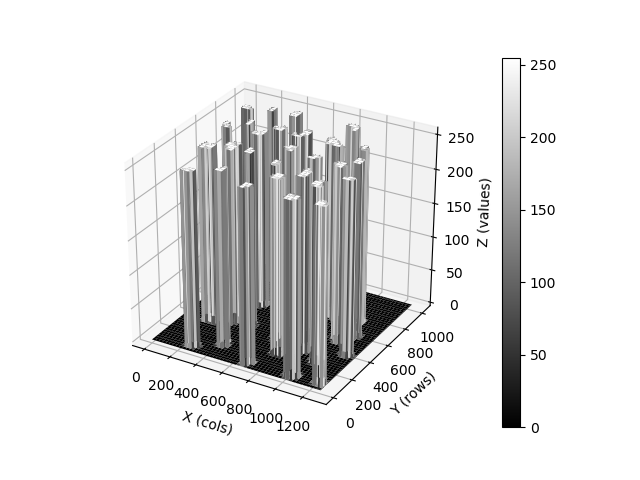

In [22]:
EE4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))

I_dilate =cv2.dilate(I_max_reg3, EE4)

plt.figure('dilate')
plt.imshow(I_dilate, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.axis('off')
plt.show()

import surface_plot as sp

(fig1, ax1, surf) = sp.surface_plot(I_dilate, cmap='gray')

fig1.colorbar(surf)

ax1.set_xlabel('X (cols)')
ax1.set_ylabel('Y (rows)')
ax1.set_zlabel('Z (values)')

plt.show()

<IPython.core.display.Javascript object>


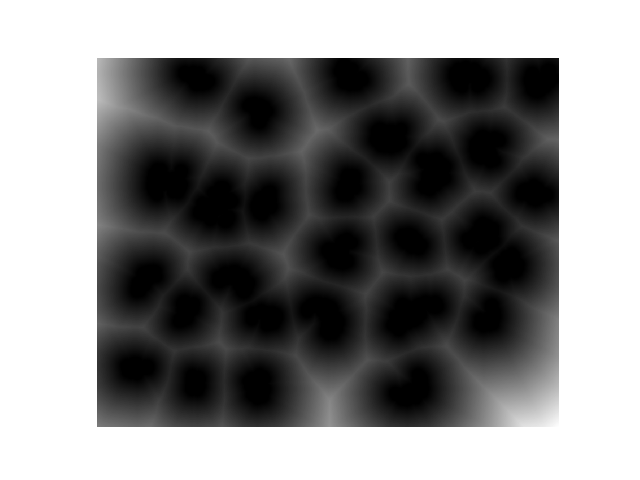

In [23]:
neg_I_dilate = 255-I_dilate
D = cv2.distanceTransform(neg_I_dilate,cv2.DIST_L2,5)

plt.figure('D')
plt.imshow(D, cmap='gray')
plt.axis('off')
plt.show()


<IPython.core.display.Javascript object>


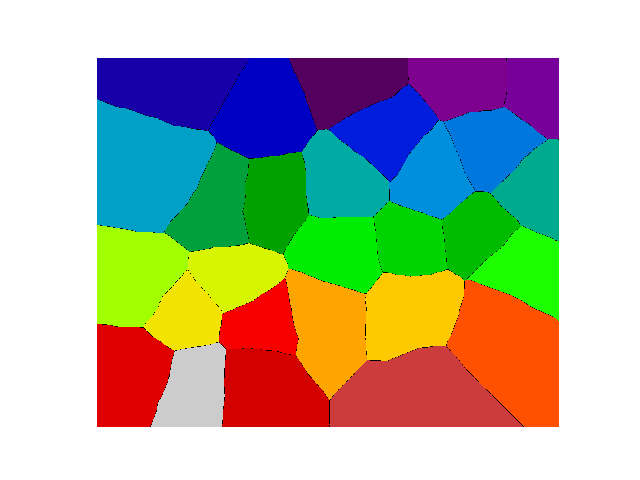

<IPython.core.display.Javascript object>


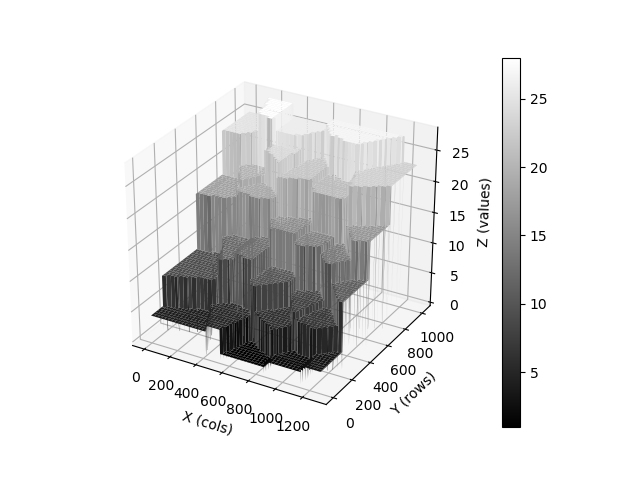

In [26]:
from skimage.morphology import watershed

DL = watershed(D,  watershed_line=True)

plt.figure('watershed 1')
plt.imshow(DL, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.axis('off')
plt.show()

import surface_plot as sp

(fig2, ax2, surf) = sp.surface_plot(DL, cmap='gray')

fig2.colorbar(surf)

ax2.set_xlabel('X (cols)')
ax2.set_ylabel('Y (rows)')
ax2.set_zlabel('Z (values)')

plt.show()


Create a binary image called bgm where the watershed lines are the foreground pixels.
[How to replace elements in a matrix](https://moonbooks.org/Articles/How-to-replace-some-elements-of-a-matrix-using-numpy-in-python-/)

<IPython.core.display.Javascript object>


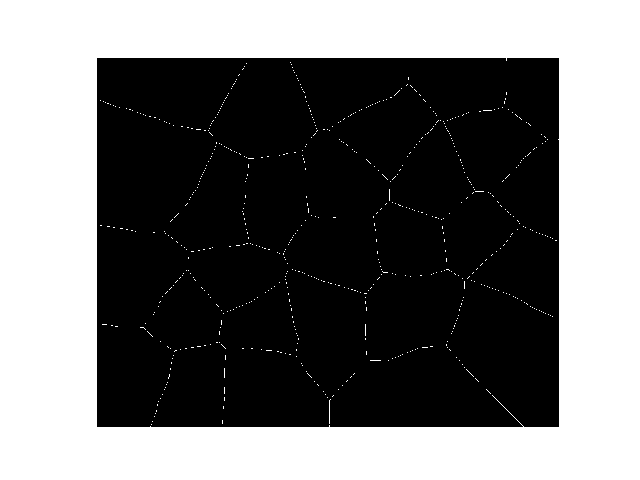

In [27]:
bgm = np.zeros(DL.shape, dtype = np.uint8)
bgm[DL == 0]= 255

plt.figure('bgm')
plt.imshow(bgm, cmap='gray', vmax = 255, vmin = 0)
plt.axis('off')
plt.show()

Now overlap this new image with the original cells image so you can appreciate where the watershed lines fall in relation to the original image.

<IPython.core.display.Javascript object>


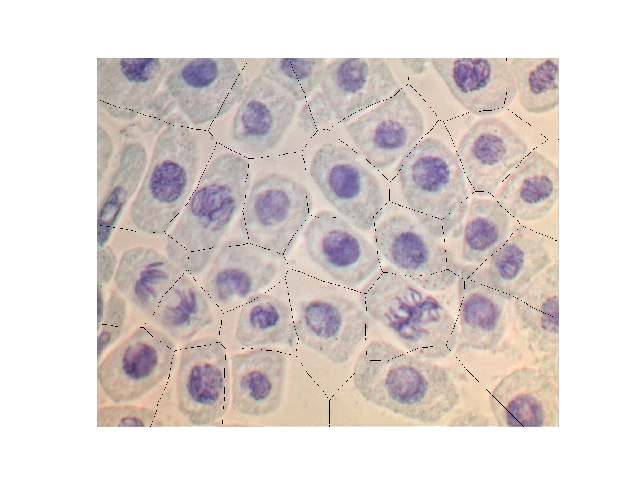

In [28]:
Inueva = cv2.imread('cells.jpg', 1)

Inueva[bgm == 255] = [0,0,0]

plt.figure('I + bgm')
plt.imshow(Inueva, cmap=plt.cm.get_cmap('nipy_spectral'))
plt.axis('off')
plt.show()

2.c. Combine the external an internal markers using mp.logical_or. Call this image I_minimos make sure it's a uint8 binary image.

bool
uint8


<IPython.core.display.Javascript object>


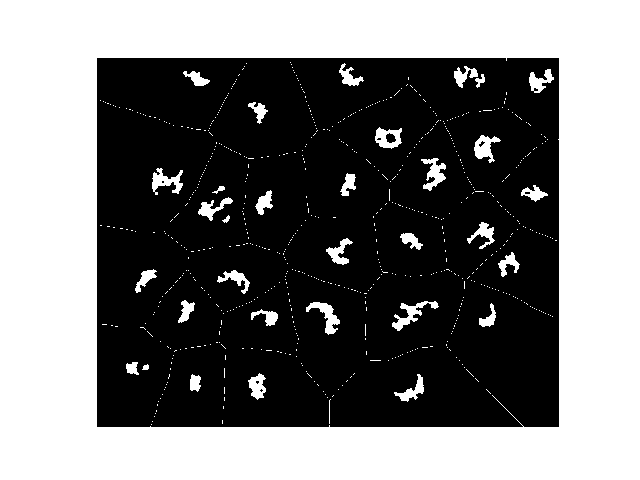

In [29]:
I_minimos = np.logical_or(I_max_reg3, bgm)
print(I_minimos.dtype)
I_minimos = np.uint8(I_minimos*255)
print(I_minimos.dtype)
plt.figure('I_minimos')
plt.imshow(I_minimos, cmap='gray', vmax = 255, vmin = 0)
plt.axis('off')
plt.show()

Now get the gradient of the original image in gray scale using a sobel high pass filter and use the function imimpose tho combine this new image with I_minimos, this funcion

<IPython.core.display.Javascript object>


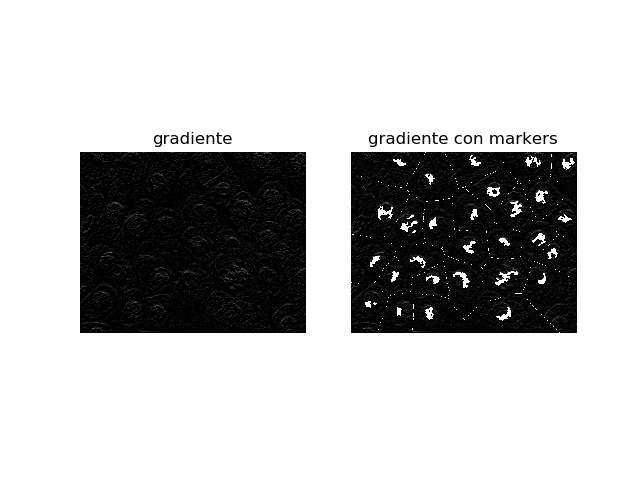

(-0.5, 1279.5, 1023.5, -0.5)

In [33]:
sobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
I_celulas_grad = cv2.filter2D(I, -1, sobel, borderType= cv2.BORDER_REFLECT)


from imimposemin import imimposemin

I_celulas_grad_mrk=imimposemin(I_celulas_grad,I_minimos)

f, axarr = plt.subplots(1, 2)

axarr[0].imshow(I_celulas_grad, cmap = 'gray', vmin = 0, vmax = 255)
axarr[0].set_title('gradiente')
axarr[0].axis('off')
axarr[1].imshow(I_celulas_grad_mrk, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1].set_title('gradiente con markers')
axarr[1].axis('off')


<IPython.core.display.Javascript object>


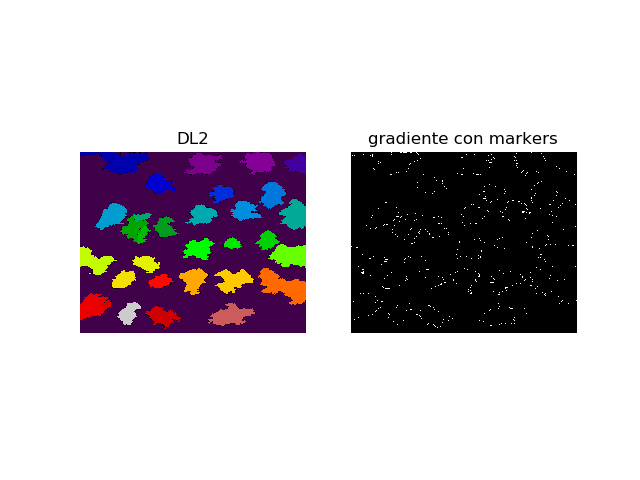

<IPython.core.display.Javascript object>


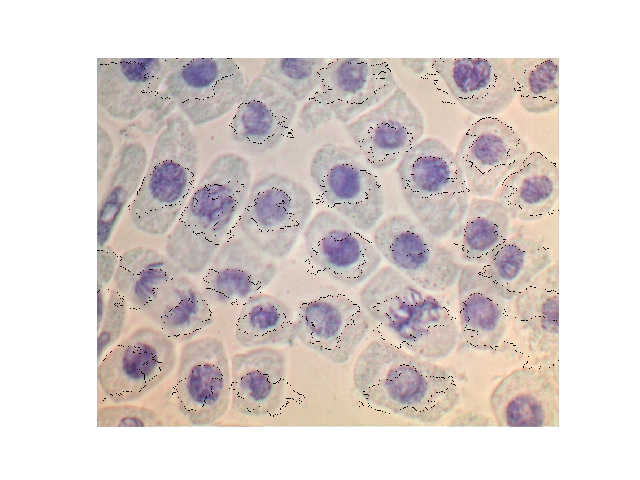

In [35]:
labelmin, NObjects= label(I_minimos, return_num=True,connectivity=2, )
labelmin = np.uint8(labelmin)
DL2 = watershed(I_celulas_grad_mrk, labelmin,watershed_line=True)
L_frontera = np.zeros(DL.shape, dtype = np.uint8)
L_frontera[DL2 == 0]= 255

f, axarr = plt.subplots(1, 2)

axarr[0].imshow(DL2, cmap=plt.cm.get_cmap('nipy_spectral'))
axarr[0].set_title('DL2')
axarr[0].axis('off')
axarr[1].imshow(L_frontera, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1].set_title('gradiente con markers')
axarr[1].axis('off')


Ifinal = cv2.imread('cells.jpg', 1)

Ifinal[L_frontera == 255] = [0,0,0]

plt.figure('final')
plt.imshow(Ifinal)
plt.axis('off')
plt.show()